# New Section

1. Collect metadata of the dataset(s)
The number of entries
Features
Value ranges (mean, percentile, ...)
2. Extract "nontrivial" information from the dataset. It is REQUIRED to use Spark MLlib.
What can you say from the data?
Any interesting data trends that cannot be easily guessed or can be used to justify some hypothesis?
3. Visualize the data (at least TWO types of nontrivial plots)
Consider: Violin/Box Plots, Histogram, Density Plot, Correlation Matrix, Hexagonal Binning

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving student_habits_performance.csv to student_habits_performance.csv


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Student Performance Analysis").getOrCreate()


spark_df = spark.read.csv('student_habits_performance.csv', header=True, inferSchema=True)


In [ ]:

print("Columns = ", spark_df.columns)
print("Column # = ", len(spark_df.columns))
print("Rows = ", spark_df.count())
print("Schema: ")
spark_df.printSchema()

spark_df.show(10)


Columns =  ['student_id', 'age', 'gender', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'parental_education_level', 'internet_quality', 'mental_health_rating', 'extracurricular_participation', 'exam_score']
Column # =  16
Rows =  1000
Schema: 
root
 |-- student_id: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- study_hours_per_day: double (nullable = true)
 |-- social_media_hours: double (nullable = true)
 |-- netflix_hours: double (nullable = true)
 |-- part_time_job: string (nullable = true)
 |-- attendance_percentage: double (nullable = true)
 |-- sleep_hours: double (nullable = true)
 |-- diet_quality: string (nullable = true)
 |-- exercise_frequency: integer (nullable = true)
 |-- parental_education_level: string (nullable = true)
 |-- internet_quality: string (nullable = true)
 |-- mental_health_rating: integer (n

In [ ]:
from pyspark.sql.functions import col, mean

study_mean = spark_df.select(mean(col('study_hours_per_day'))).show()
sleep_mean = spark_df.select(col('sleep_hours')).describe().show()
netflix_hours_mean = spark_df.select(col('netflix_hours')).describe().show()
social_media_hours_mean = spark_df.select((col('social_media_hours'))).describe().show()
attendance_percentage_mean = spark_df.select(col('attendance_percentage')).describe().show()
exam_mean = spark_df.select(col('exam_score')).describe().show()
age_mean = spark_df.select(col('age')).describe().show()
mental_health = spark_df.select(col('mental_health_rating')).describe().show()
exercise_frequency = spark_df.select(col('exercise_frequency')).describe().show()




+------------------------+
|avg(study_hours_per_day)|
+------------------------+
|                  3.5501|
+------------------------+

+-------+------------------+
|summary|       sleep_hours|
+-------+------------------+
|  count|              1000|
|   mean| 6.470099999999999|
| stddev|1.2263767732593391|
|    min|               3.2|
|    max|              10.0|
+-------+------------------+

+-------+------------------+
|summary|     netflix_hours|
+-------+------------------+
|  count|              1000|
|   mean|1.8197000000000014|
| stddev|1.0751175692861632|
|    min|               0.0|
|    max|               5.4|
+-------+------------------+

+-------+------------------+
|summary|social_media_hours|
+-------+------------------+
|  count|              1000|
|   mean| 2.505500000000002|
| stddev| 1.172422417187732|
|    min|               0.0|
|    max|               7.2|
+-------+------------------+

+-------+---------------------+
|summary|attendance_percentage|
+-------+-----

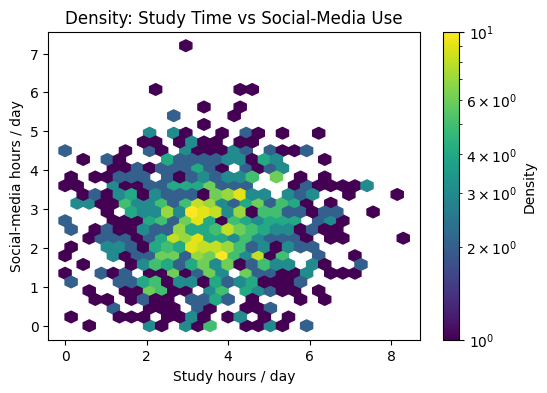

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns

pdf = spark_df.select("study_hours_per_day", "social_media_hours").toPandas()
plt.figure(figsize=(6,4))
plt.hexbin(pdf["study_hours_per_day"], pdf["social_media_hours"], gridsize=28, bins='log')
plt.colorbar(label="Density")
plt.xlabel("Study hours / day")
plt.ylabel("Social‑media hours / day")
plt.title("Density: Study Time vs Social‑Media Use")
plt.show()

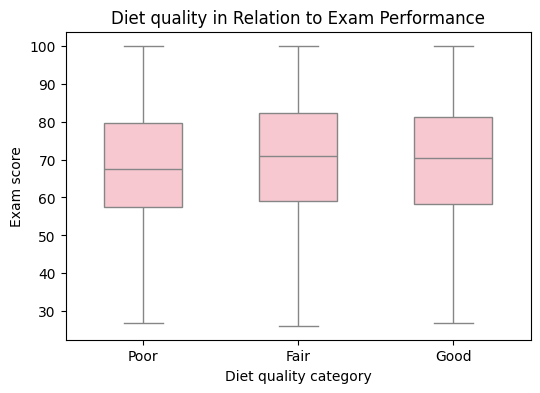

In [ ]:
pdf = (spark_df.select("diet_quality", "exam_score")
                .filter("diet_quality IS NOT NULL")
                .toPandas())

plt.figure(figsize=(6,4))
order = ["Poor", "Fair", "Good"]           # consistent x‑axis
sns.boxplot(x="diet_quality", y="exam_score", data=pdf, order=order,
            width=.5, showfliers=False, color = "Pink")
plt.title("Diet quality in Relation to Exam Performance")
plt.xlabel("Diet quality category")
plt.ylabel("Exam score")
plt.show()

##Machine Learning

In [ ]:
train_df, test_df = spark_df.randomSplit([.8, .2], seed=42)
print(train_df.count(), test_df.count())

838 162


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

# Combining all features into a single vector
# Get the catgorical columns
categorical_cols = [
    "student_id",
    "part_time_job",
    "gender",
    "diet_quality",
    "internet_quality",
    "parental_education_level",
    "extracurricular_participation"
]
#Indexers
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep")
    for col in categorical_cols
]
#Get the numerical columns
numerical_cols = [
    "age",
    "study_hours_per_day",
    "social_media_hours",
    "netflix_hours",
    "attendance_percentage",
    "sleep_hours",
    "exercise_frequency",
    "mental_health_rating"
]
final_columns = numerical_cols + [col + "_index" for col in categorical_cols]
assembler = VectorAssembler(
    inputCols=final_columns,
    outputCol="features"
)
lr = LinearRegression(
    featuresCol="features",
    labelCol="exam_score",
    maxIter=10,
    regParam=0.1
)

pipeline = Pipeline(stages=indexers + [assembler, lr])
pipelineModel = pipeline.fit(train_df)
#Predict on test df using pipeline model
predDf = pipelineModel.transform(test_df)

# Show predictions
print("Predictions:")
predDf.select("student_id", "exam_score", "prediction").show(10)

evaluator = RegressionEvaluator(
    labelCol="exam_score",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = evaluator.evaluate(predDf)
print(f"RMSE on test data = {rmse}")

r2 = evaluator.setMetricName("r2").evaluate(predDf)
print(f"R-squared on test data = {r2}")


Predictions:
+----------+----------+------------------+
|student_id|exam_score|        prediction|
+----------+----------+------------------+
|     S1002|      34.3|41.751926267544064|
|     S1006|      89.8|  88.0719667647906|
|     S1008|      78.9| 72.76215755708176|
|     S1013|      75.8| 72.67851811798049|
|     S1019|      45.3| 42.52479860503283|
|     S1023|      43.7| 44.25717612891815|
|     S1029|      75.7| 61.65093697409722|
|     S1035|      72.6| 74.07940547325519|
|     S1045|      75.1| 71.75694869914263|
|     S1046|      71.0|  70.7591868138926|
+----------+----------+------------------+
only showing top 10 rows

RMSE on test data = 5.664291136734634
R-squared on test data = 0.901192322253241


##Command Logs